## Обучить полносвязную модель на MNIST

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
import matplotlib.pyplot as plt


train_dataset = datasets.MNIST('/Users/novikov-pw/Pythoning/MNIST', train = True, download=False)
test_dataset = datasets.MNIST('/Users/novikov-pw/Pythoning/MNIST', train = False, download=False)

# Parameters
num_epoch = 10
cuda_device = -1
batch_size = 140
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
input_d = 28*28
hidden_d = 512
out_d = 10

In [20]:
print(torch.__version__)           # 1.9.0
print(torch.version.cuda)           # 11.1
print(torch.cuda.is_available())     #True
# device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(type(device))
print(device)


1.12.0+cpu
None
False
<class 'torch.device'>
cpu


In [21]:
class NN(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 out_dim: int,
                 ):
        super().__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.dropout1 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.dropout2 = nn.Dropout(0.1)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.dropout3 = nn.Dropout(0.1)
        self.linear4 = nn.Linear(hidden_dim, out_dim)

        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.dropout3(self.activation(self.linear3(x)))
        x = self.sigmoid(self.linear4(x))

        return x


def collate_fn(data):
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])

    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255, 
        'target': torch.from_numpy(numpy.array(targets))
    }

In [22]:
# Model
modelNN = NN(input_d, hidden_d, out_d)
modelNN = modelNN.to(device)
modelNN.train()

# Optimizator
optim = torch.optim.Adam(modelNN.parameters(), lr=lr)

# Loss function
criterion = nn.CrossEntropyLoss()

In [24]:
# Train
for epoch in range(num_epoch):
    print(f'epoch: {epoch}')
    data_loader = DataLoader(dataset=train_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    for step, batch in enumerate(data_loader):
        optim.zero_grad()
        data = batch['data'].to(device).float()
        predict = modelNN(data.view(data.size(0), -1))
        loss = criterion(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
    print(loss)

epoch: 0
tensor(1.5013, grad_fn=<NllLossBackward0>)
epoch: 1
tensor(1.4925, grad_fn=<NllLossBackward0>)
epoch: 2
tensor(1.4743, grad_fn=<NllLossBackward0>)
epoch: 3
tensor(1.4938, grad_fn=<NllLossBackward0>)
epoch: 4
tensor(1.4819, grad_fn=<NllLossBackward0>)
epoch: 5
tensor(1.4658, grad_fn=<NllLossBackward0>)
epoch: 6
tensor(1.4923, grad_fn=<NllLossBackward0>)
epoch: 7
tensor(1.4848, grad_fn=<NllLossBackward0>)
epoch: 8
tensor(1.4762, grad_fn=<NllLossBackward0>)
epoch: 9
tensor(1.4748, grad_fn=<NllLossBackward0>)


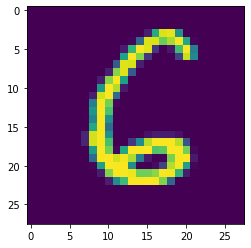

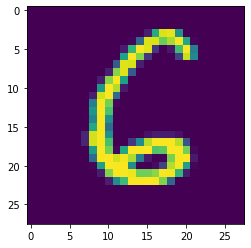

In [37]:
test = test_dataset.test_data[98].view(1, -1).float() / 255
plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()
predict = modelNN(test)
plt.imshow(test[0].unsqueeze(axis=0).view(28, 28).detach().numpy())
plt.show()

## Обучить глубокую сверточную сеть на MNIST

In [29]:
# Parameters
input_d = 1
hidden_d = 512
hidden_d1 = 128
hidden_d2 = 256
hidden_d3 = 128
out_d = 10

In [30]:
class CNN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels1: int,
                 hidden_channels2: int,
                 hidden_channels3: int,
                 n_classes: int,
                 ):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_channels1, kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(hidden_channels1)
        self.conv2 = nn.Conv2d(hidden_channels1, hidden_channels2, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels2)
        self.conv3 = nn.Conv2d(hidden_channels2, hidden_channels3, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(hidden_channels3)
        self.conv4 = nn.Conv2d(hidden_channels3, 1, kernel_size=1, padding=0, stride=1)
        self.linear1 = nn.Linear(14*14, n_classes, bias=True)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.conv4(x))
        x = self.activation(self.linear1(x.view(x.size(0), -1)))

        return x


def collate_fn(data):
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])

    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255, 
        'target': torch.from_numpy(numpy.array(targets))
    }

In [31]:
# Model
modelCNN = CNN(input_d, hidden_d1, hidden_d2, hidden_d3, out_d)
modelCNN = modelCNN.to(device)
modelCNN.train()

# Optimizator
optim = torch.optim.Adam(modelCNN.parameters(), lr=lr)

# Loss function
criterion = nn.CrossEntropyLoss()

In [32]:
# Train
for epoch in range(num_epoch):
    print(f'epoch: {epoch}')
    data_loader = DataLoader(dataset=train_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    for step, batch in enumerate(data_loader):
        optim.zero_grad()
        data = batch['data'].to(device).float()
        predict = modelNN(data.view(data.size(0), -1))
        loss = criterion(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
    print(loss)

epoch: 0
tensor(1.4650, grad_fn=<NllLossBackward0>)
epoch: 1
tensor(1.4669, grad_fn=<NllLossBackward0>)
epoch: 2
tensor(1.4759, grad_fn=<NllLossBackward0>)
epoch: 3
tensor(1.4805, grad_fn=<NllLossBackward0>)
epoch: 4
tensor(1.4813, grad_fn=<NllLossBackward0>)
epoch: 5
tensor(1.4635, grad_fn=<NllLossBackward0>)
epoch: 6
tensor(1.4744, grad_fn=<NllLossBackward0>)
epoch: 7
tensor(1.5005, grad_fn=<NllLossBackward0>)
epoch: 8
tensor(1.4753, grad_fn=<NllLossBackward0>)
epoch: 9
tensor(1.4774, grad_fn=<NllLossBackward0>)


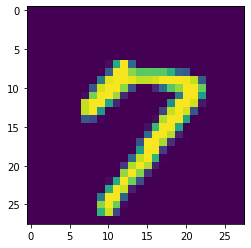

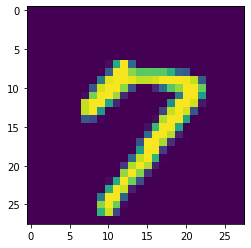

In [39]:
test = test_dataset.test_data[9979].view(1, -1).float() / 255
plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()
predict = modelNN(test)
plt.imshow(test[0].unsqueeze(axis=0).view(28, 28).detach().numpy())
plt.show()